In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import sys
import rich


import xobjects as xo
import xtrack as xt
import xpart as xp

sys.path.append('../')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt


LINEFOLDER   = '../Data/Lines/'
SURVEYFOLDER = '../Data/Surveys/'
df_columns = ['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'mux', 'muy', 'qx', 'qy', 'qs', 'dqx', 'dqy']


line   = {}
twiss  = {}
survey = {}

# Importing survey
for seq in ['lhcb1','lhcb2']:
    _beam = seq[-2:]
    survey[_beam] = pd.read_pickle(SURVEYFOLDER + f'survey_opticsfile32_{seq}.pkl')

# Importing twiss
for seq in ['lhcb1','lhcb4']:
    _beam = seq[-2:]
    
    # Importing Line
    line[_beam] = xPlus.importLine(LINEFOLDER + f'line_opticsfile32_{seq}.json')
    
    # Importing twiss and tracker
    if _beam == 'b1':
        tracker = xt.Tracker(line=line[_beam])
        xtwiss  = tracker.twiss()
    else:
        xtwiss  = xt.Tracker(line=line[_beam]).twiss()
    
    twiss[_beam]= pd.DataFrame(xtwiss,columns = df_columns)
    twiss[_beam].set_index('name',inplace=True)


# Creating twiss b2 from b4
#==========================================
twiss['b2'] = xPlus.twiss_b2_from_b4(twiss['b4'])



# Clearing xsuite ouput
clear_output(wait=False)






# Filtering twiss (Needed for IP objects)
#====================================
twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..','bbcw'])
#====================================
B1 = inp.Beam('b1',twiss['b1'],survey['b1'],
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)
    
B2 = inp.Beam('b2',twiss['b2'],survey['b2'],
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)

IP1 = inp.InteractionPoint('ip1',B1,B2)
IP5 = inp.InteractionPoint('ip5',B1,B2)


beam = 'b1'
# Deactivating all wires
#===================================================
tracker.vars['enable_qff'] = 0
for IP in ['ip1','ip5']:
    tracker.vars[f"bbcw_rw_{IP}.{beam}"] = 1
    tracker.vars[f"bbcw_i_{IP}.{beam}"]  = 0

    
# Creating BB knobs
#===================================================
allVars = list(tracker.vars._owner.keys())
allElements = list(tracker.element_refs._owner.keys())


for _ip in ['ip1','ip5','ip2','ip8']:
    bb_lr = [name for name in allElements if ('bb_lr' in name)&(f'{_ip[-1]}b1' in name)]
    bb_ho = [name for name in allElements if ('bb_ho' in name)&(f'{_ip[-1]}b1' in name)]

    # New knob:
    tracker.vars[f'{_ip}_bblr_ON'] = 1
    tracker.vars[f'{_ip}_bbho_ON'] = 1

    # Linking to new knob
    for _lr in bb_lr:
        tracker.element_refs[_lr].n_particles      = tracker.vars[f'{_ip}_bblr_ON']*tracker.element_refs[_lr].n_particles._value
    for _ho in bb_ho:
        tracker.element_refs[_ho].slices_other_beam_num_particles = tracker.vars[f'{_ip}_bbho_ON']*tracker.element_refs[_ho].slices_other_beam_num_particles._value[0]

# Creating sext and oct knobs
#====================================================
ks = [name for name in allVars if ('ksf' in name)|('ksd' in name)]
ko = [name for name in allVars if ('kof.a' in name)|('kod.a' in name)]

tracker.vars['all_oct_ON']  = 1
tracker.vars['all_sext_ON'] = 1
for _ks in ks:
    if tracker.vars[_ks]._expr is None:
        tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._value
    else:
        tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._expr 
for _ko in ko:
    if tracker.vars[_ko]._expr is None:
        tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._value
    else:
        tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._expr 

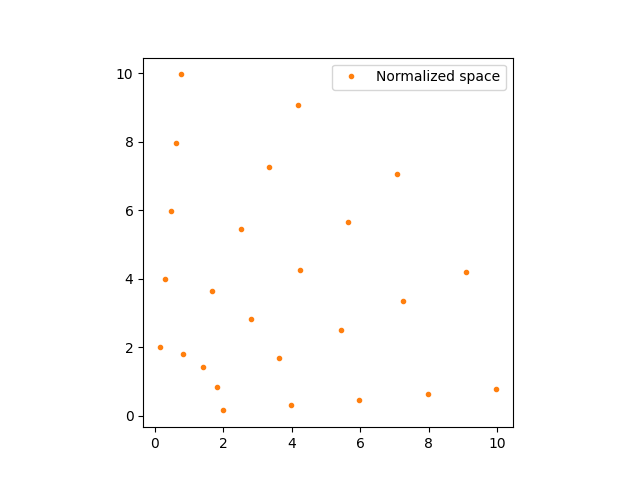

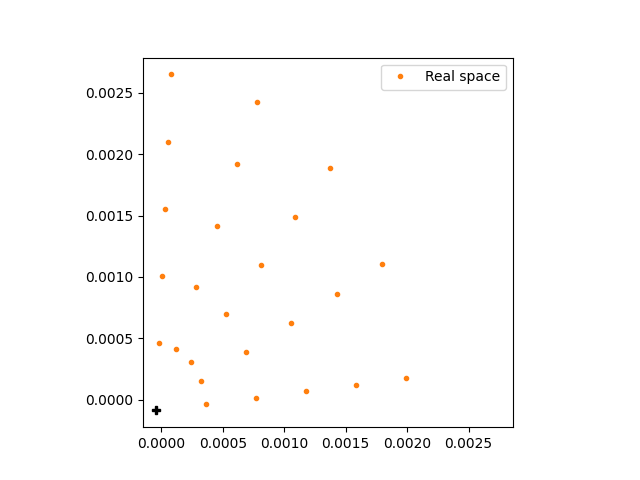

In [54]:

def generate_particles():
    # Generating Coord grid
    #=========================================================
    coordinates = phys.polar_grid(  r_sig     = np.linspace(2,10,5),
                                    theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,5),
                                    emitt     = [B1.emittx,B1.emitty])



    # Generation
    p0        = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
    particles = xp.build_particles( particle_ref = p0,
                                    tracker      = tracker,
                                    x_norm       = coordinates['x_sig'].values, 
                                    px_norm      = None, 
                                    y_norm       = coordinates['y_sig'].values, 
                                    py_norm      = None,
                                    zeta         = None,
                                    delta        = None,
                scale_with_transverse_norm_emitt = [B1.emittx_n,B1.emitty_n])
    
    return particles,coordinates



particles,coordinates = generate_particles()


plt.figure()
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'.',color='C1',label='Normalized space')
plt.axis('square')
plt.legend()


_tmp_twiss = pd.DataFrame(tracker.twiss(),columns = df_columns)
_tmp_twiss.set_index('name',inplace=True)
plt.figure()
plt.plot(particles.x   ,particles.y    ,'.',color='C1',label='Real space')
plt.plot(_tmp_twiss.loc['ip3','x'],_tmp_twiss.loc['ip3','y'],'P',color='k')
plt.axis('square')
plt.legend()



---

# Tracking

In [ ]:


# Matching
#===================================
for _ip in ['ip1','ip5','ip2','ip8']:
    tracker.vars[f'{_ip}_bblr_ON'] = 0
    tracker.vars[f'{_ip}_bbho_ON'] = 0

tracker.vars['all_oct_ON']   = 1
tracker.vars['all_sext_ON']  = 1
tracker.match(vary=['dqx.b1','dqy.b1'], 
    targets = [
        ('qx', 62.31),
        ('qy', 60.32)])
tracker.match(vary=['dqpx.b1_sq','dqpy.b1_sq'],
    targets = [
        ('dqx', 15.0),
        ('dqy', 15.0)])

tw_final = tracker.twiss()
Qx_0,Qy_0 = np.round(np.mod(tw_final['qx'],1),4),np.round(np.mod(tw_final['qy'],1),4)
print('\nFinal twiss parameters')
print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
      f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
#===================================


Output()

(0.295, 0.34500000000000003)

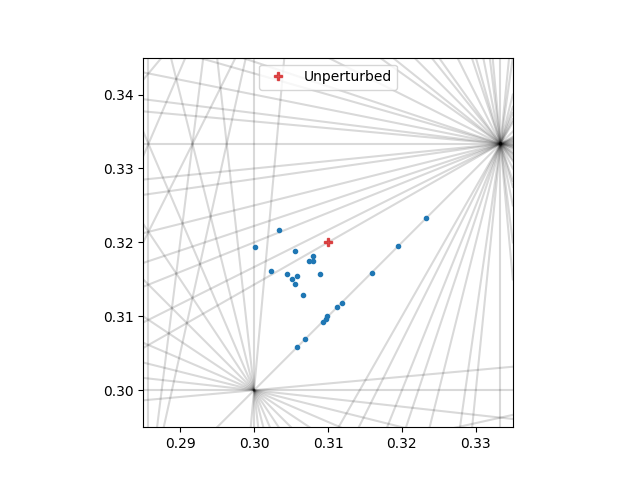

In [112]:


# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 1
tracker.vars[f'ip5_bbho_ON'] = 1

tracker.vars[f'ip1_bblr_ON'] = 1
tracker.vars[f'ip5_bblr_ON'] = 1

tracker.vars['all_oct_ON']   = 0
tracker.vars['all_sext_ON']  = 1
#==========================


particles,coordinates = generate_particles()

# Try zeroing longitudinal
#particles.zeta *= 0
#particles.delta *= 0
tracked = xPlus.Tracking(tracker, particles, n_turns = 1024,progress=True)
trackTwiss = pd.DataFrame(tracker.twiss(),columns = df_columns)
trackTwiss.set_index('name',inplace=True)

window    = 0.05
Qx_lim    = [Qx_0-window/2,Qx_0+window/2]
Qy_lim    = [Qy_0-window/2,Qy_0+window/2]

plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)
plt.plot(tracked.tunes['Qx'],tracked.tunes['Qy'],'.')
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend()
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)




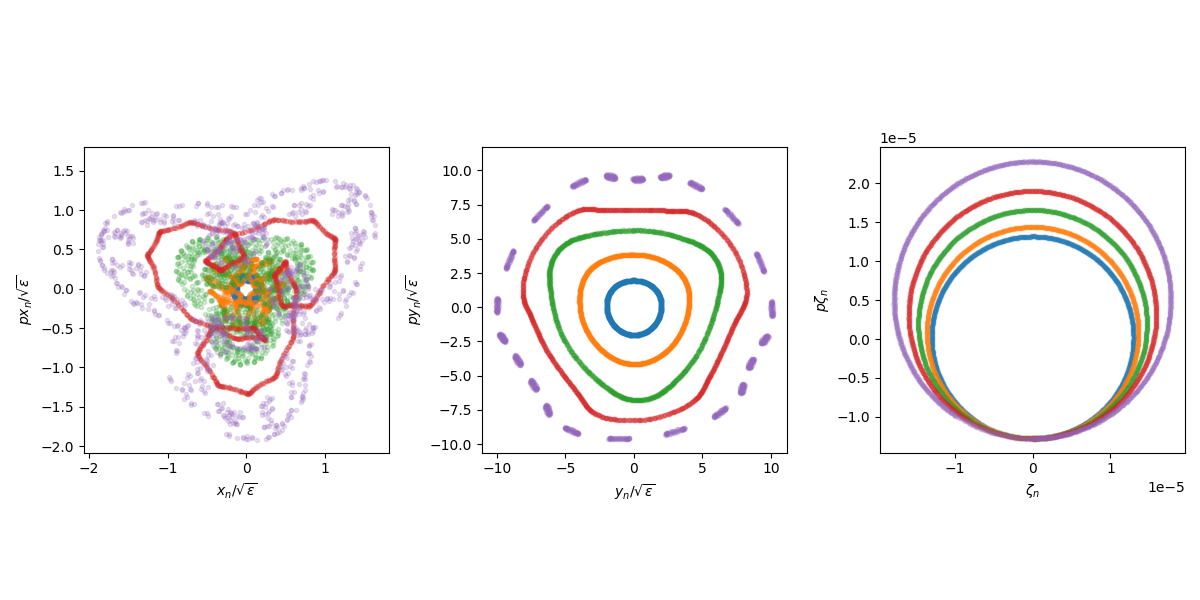

In [119]:

%matplotlib widget
theta_vec = np.linspace(0,2*np.pi,200)
plt.figure(figsize=(12,6))
for _ID,_part in tracked.df.groupby('particle'):
    
    if coordinates.loc[_ID,'theta_sig']==np.linspace(0.05*np.pi/2,0.95*np.pi/2,5)[4]:
        #plt.plot(_part.turn,np.sqrt(2*Jx)/np.sqrt(B1.emittx),alpha=0.5)
        plt.subplot(1,3,1)
        plt.plot(_part.x_n/np.sqrt(B1.emittx),_part.px_n/np.sqrt(B1.emittx),'.',alpha=0.2)
        this_color = plt.gca().lines[-1].get_color()
        #plt.plot(coordinates.loc[_ID,'x_n']*np.cos(theta_vec)/np.sqrt(B1.emittx),coordinates.loc[_ID,'x_n']*np.sin(theta_vec)/np.sqrt(B1.emittx),alpha=0.8,color=plt.gca().lines[-1].get_color())
        plt.subplot(1,3,2)
        plt.plot(_part.y_n/np.sqrt(B1.emitty),_part.py_n/np.sqrt(B1.emitty),'.',color=this_color,alpha=0.2)
        #plt.plot(coordinates.loc[_ID,'y_n']*np.cos(theta_vec)/np.sqrt(B1.emitty),coordinates.loc[_ID,'y_n']*np.sin(theta_vec)/np.sqrt(B1.emitty),alpha=0.8,color=plt.gca().lines[-1].get_color())
        plt.subplot(1,3,3)
        plt.plot(_part.zeta_n,_part.pzeta_n,'.',color=this_color,alpha=0.2)
#plt.xlim([0,200])
plt.subplot(1,3,1)
plt.axis('square')
plt.xlabel(r'$x_n/\sqrt{\varepsilon}$')
plt.ylabel(r'$px_n/\sqrt{\varepsilon}$')
plt.subplot(1,3,2)
plt.axis('square')
plt.xlabel(r'$y_n/\sqrt{\varepsilon}$')
plt.ylabel(r'$py_n/\sqrt{\varepsilon}$')
plt.subplot(1,3,3)
plt.axis('square')
plt.xlabel(r'$\zeta_n$')
plt.ylabel(r'$p\zeta_n$')
#plt.ylim([-1e-4,1e-4])

plt.tight_layout()

In [50]:
for _ID,_part in tracked.df.groupby('particle'):
    
    if np.mod(_ID,4)==0:
        print(coordinates.loc[_ID,'r_sig'])

0.02
0.1
0.08
0.06
0.04
0.02
0.1


0.7853981633974483

In [76]:
[k/np.pi for k in coordinates.groupby('theta_sig').groups.keys()]

[0.025, 0.1375, 0.25, 0.3625, 0.475]

In [104]:
def invert_matrix(A, tol=None):
    """
    Returns the inverse of the passed in matrix.
        :param A: The matrix to be inversed
 
        :return: The inverse of the matrix A
    """

 
    # Section 2: Make copies of A & I, AM & IM, to use for row ops
    n = len(A)
    AM = A.copy()
    I = np.eye(n)
    IM = I.copy()
 
    # Section 3: Perform row operations
    indices = list(range(n)) # to allow flexible row referencing ***
    for fd in range(n): # fd stands for focus diagonal
        fdScaler = 1.0 / AM[fd][fd]
        # FIRST: scale fd row with fd inverse. 
        for j in range(n): # Use j to indicate column looping.
            AM[fd][j] *= fdScaler
            IM[fd][j] *= fdScaler
        # SECOND: operate on all rows except fd row as follows:
        for i in indices[0:fd] + indices[fd+1:]: 
            # *** skip row with fd in it.
            crScaler = AM[i][fd] # cr stands for "current row".
            for j in range(n): 
                # cr - crScaler * fdRow, but one element at a time.
                AM[i][j] = AM[i][j] - crScaler * AM[fd][j]
                IM[i][j] = IM[i][j] - crScaler * IM[fd][j]
    return IM
 
def print_matrix(Title, M):
    print(Title)
    for row in M:
        print([round(x,3)+0 for x in row])

W_matrix = tw_final['W_matrix'][0]
print_matrix('W',W_matrix)
print_matrix('W_linalg',np.linalg.inv(W_matrix))
print_matrix('W_invert',invert_matrix(W_matrix))

W
[10.999, 0.0, -0.172, -0.678, 0.0, -0.009]
[-0.208, 0.091, 0.009, 0.011, 0.0, 0.0]
[0.245, -0.909, 14.753, 0.0, 0.0, 0.014]
[0.007, -0.01, 0.178, 0.068, 0.0, 0.0]
[0.17, -0.022, -0.021, 0.016, 28.129, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.036]
W_linalg
[0.091, 0.0, -0.01, 0.909, 0.0, 0.022]
[0.208, 10.999, -0.007, 0.245, 0.0, 0.17]
[0.011, 0.678, 0.068, 0.0, 0.0, -0.016]
[-0.009, -0.172, -0.178, 14.753, 0.0, -0.02]
[0.0, 0.009, 0.0, -0.014, 0.036, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 28.129]
W_invert
[0.091, 0.0, -0.01, 0.909, 0.0, 0.022]
[0.208, 10.999, -0.007, 0.245, 0.0, 0.17]
[0.011, 0.678, 0.068, 0.0, 0.0, -0.016]
[-0.009, -0.172, -0.178, 14.753, 0.0, -0.02]
[0.0, 0.009, 0.0, -0.014, 0.036, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 28.129]


In [105]:
particle_on_co = tracker.find_closed_orbit(particle_co_guess=xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c))


AttributeError: 'dict' object has no attribute 'W_matrix'

In [126]:
np.linalg.inv(tw_final.W_matrix[0])

array([[ 9.05446103e-02,  8.79097990e-08, -9.93762020e-03,
         9.09385287e-01, -1.10756434e-07,  2.17030686e-02],
       [ 2.07716887e-01,  1.09990031e+01, -7.18339455e-03,
         2.44816151e-01, -2.64464119e-07,  1.69909533e-01],
       [ 1.13013964e-02,  6.77992008e-01,  6.75053921e-02,
         1.08966100e-07, -1.30095489e-07, -1.63704081e-02],
       [-8.91018022e-03, -1.71787655e-01, -1.78321852e-01,
         1.47529014e+01, -2.35834123e-07, -2.03944528e-02],
       [-3.74241026e-04,  9.04337694e-03,  2.07054163e-04,
        -1.38437244e-02,  3.55504870e-02, -8.17797162e-07],
       [-1.75517344e-06,  6.91989509e-05, -1.37687445e-07,
        -1.31149392e-05,  1.55390067e-04,  2.81290111e+01]])

In [142]:
phys2norm(**tracked.df[['x','px','y','py','zeta','delta']],twiss=tw_final,to_pd=True)

,x,px,y,py,zeta,delta
0,0.000037,-1.224109e-13,2.914428e-06,1.683130e-12,-2.218476e-07,-0.000014
1,-0.000014,-3.451629e-05,-1.233194e-06,-2.652323e-06,-5.493424e-08,-0.000014
2,-0.000027,2.569876e-05,-1.888799e-06,2.249723e-06,1.097923e-07,-0.000014
3,0.000034,1.596233e-05,2.843858e-06,7.535871e-07,2.759796e-07,-0.000014
4,0.000002,-3.753845e-05,-5.255703e-07,-2.904797e-06,4.422686e-07,-0.000014
...,...,...,...,...,...,...
25595,-0.000002,2.704823e-05,-1.528427e-04,-1.068966e-04,-1.095514e-05,-0.000010
25596,0.000027,-6.842301e-06,-3.183827e-05,1.843098e-04,-1.079980e-05,-0.000011
25597,-0.000020,-2.099686e-05,1.801475e-04,-5.031429e-05,-1.059441e-05,-0.000011
25598,-0.000008,2.885607e-05,-1.232336e-04,-1.415529e-04,-1.040100e-05,-0.000011


In [146]:
pd.concat([tracked.df,phys2norm(**tracked.df[['x','px','y','py','zeta','delta']],twiss=tw_final,to_pd=True)],axis=1)

,turn,particle,x,px,y,py,zeta,delta,state,x_n,px_n,y_n,py_n,zeta_n,delta_n
0,0,0,0.000360,-7.168598e-06,-0.000034,-5.250071e-07,0.000000,0.000000e+00,1,0.000037,-1.224109e-13,2.914428e-06,1.683130e-12,-2.218476e-07,-0.000014
1,1,0,-0.000197,2.106501e-07,-0.000077,-1.466242e-06,-0.000003,-9.360857e-11,1,-0.000014,-3.451629e-05,-1.233194e-06,-2.652323e-06,-5.493424e-08,-0.000014
2,2,0,-0.000347,8.487997e-06,-0.000144,-1.946621e-06,-0.000002,-1.184157e-10,1,-0.000027,2.569876e-05,-1.888799e-06,2.249723e-06,1.097923e-07,-0.000014
3,3,0,0.000326,-5.077485e-06,-0.000051,-6.674090e-07,0.000013,-4.503864e-11,1,0.000034,1.596233e-05,2.843858e-06,7.535871e-07,2.759796e-07,-0.000014
4,4,0,-0.000023,-3.349250e-06,-0.000059,-1.213300e-06,0.000014,7.643886e-11,1,0.000002,-3.753845e-05,-5.255703e-07,-2.904797e-06,4.422686e-07,-0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25595,1019,24,0.000034,7.239917e-07,-0.002366,-3.606215e-05,-0.000308,1.243187e-07,1,-0.000002,2.704823e-05,-1.528427e-04,-1.068966e-04,-1.095514e-05,-0.000010
25596,1020,24,0.000127,-3.856581e-06,-0.000543,5.713737e-06,-0.000295,1.197737e-07,1,0.000027,-6.842301e-06,-3.183827e-05,1.843098e-04,-1.079980e-05,-0.000011
25597,1021,24,-0.000258,3.691169e-06,0.002586,2.748596e-05,-0.000305,1.153620e-07,1,-0.000020,-2.099686e-05,1.801475e-04,-5.031429e-05,-1.059441e-05,-0.000011
25598,1022,24,-0.000017,2.062114e-06,-0.001933,-3.318477e-05,-0.000294,1.109010e-07,1,-0.000008,2.885607e-05,-1.232336e-04,-1.415529e-04,-1.040100e-05,-0.000011


In [144]:
tracked.df.insert

,turn,particle,x,px,y,py,zeta,delta,state
0,0,0,0.000360,-7.168598e-06,-0.000034,-5.250071e-07,0.000000,0.000000e+00,1
1,1,0,-0.000197,2.106501e-07,-0.000077,-1.466242e-06,-0.000003,-9.360857e-11,1
2,2,0,-0.000347,8.487997e-06,-0.000144,-1.946621e-06,-0.000002,-1.184157e-10,1
3,3,0,0.000326,-5.077485e-06,-0.000051,-6.674090e-07,0.000013,-4.503864e-11,1
4,4,0,-0.000023,-3.349250e-06,-0.000059,-1.213300e-06,0.000014,7.643886e-11,1
...,...,...,...,...,...,...,...,...,...
25595,1019,24,0.000034,7.239917e-07,-0.002366,-3.606215e-05,-0.000308,1.243187e-07,1
25596,1020,24,0.000127,-3.856581e-06,-0.000543,5.713737e-06,-0.000295,1.197737e-07,1
25597,1021,24,-0.000258,3.691169e-06,0.002586,2.748596e-05,-0.000305,1.153620e-07,1
25598,1022,24,-0.000017,2.062114e-06,-0.001933,-3.318477e-05,-0.000294,1.109010e-07,1


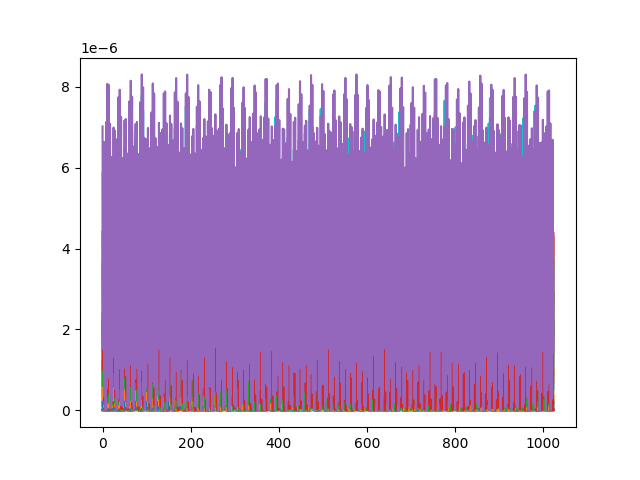

In [95]:
plt.figure()
for _ID,_part in tracked.df.groupby('particle'):
    plt.plot(_part.turn,_part.y**2+_part.py**2)

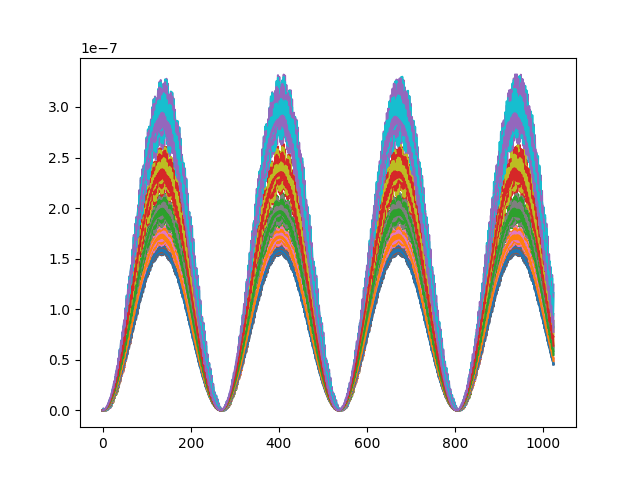

In [87]:
plt.figure()
for _ID,_part in tracked.df.groupby('particle'):
    plt.plot(_part.turn,_part.delta**2+_part.delta*_part.zeta+_part.zeta**2)

In [94]:
tracked.particles.x == particles.x

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

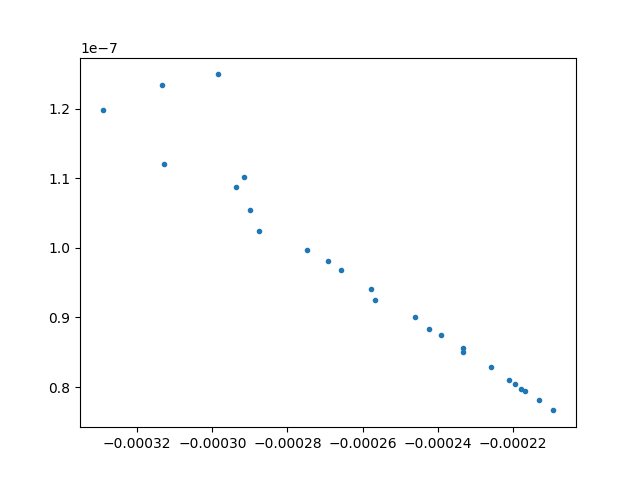

In [91]:
plt.figure()
plt.plot(tracked.particles.to_pandas()['zeta'],tracked.particles.to_pandas()['delta'],'.')

(0.295, 0.34500000000000003)

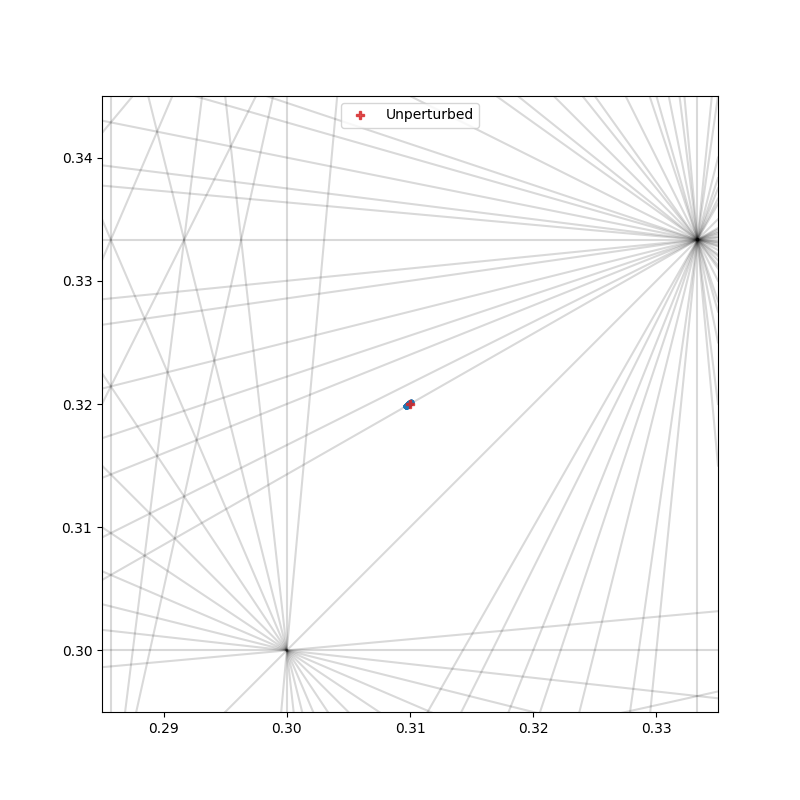

In [43]:
%matplotlib widget

window    = 0.05
Qx_lim    = [Qx_0-window/2,Qx_0+window/2]
Qy_lim    = [Qy_0-window/2,Qy_0+window/2]

plt.figure(figsize=(8,8))
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)
tracked._tunesMTD = 'pynaff'
bbplt.polarmesh(tracked.tunes['Qx'],tracked.tunes['Qy'],r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.plot(tracked.tunes['Qx'],tracked.tunes['Qy'],'.')
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')


plt.legend()
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)